In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
# данные для обучения
#БЕ - Бизнес-единица, по отношению к которой проведена транзакция
#Дата транзакции - Дата совершения транзакции
#Cумма в RUB - Сумма транзакции, выраженная в рублях

data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
#Разбивка по бизнес единицам, для удобства рассмотрения
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
# Делаем постоянное разрешение в 1 день и заполняем 0 появившиеся даты
train_2_1d = train_2.resample('1D').sum()

In [10]:
# Подгонка под формат darts
train_2_1d_reindex = train_2_1d.reset_index(inplace=False)

In [11]:
# Перевод в формат, понятный darts
series_1d = TimeSeries.from_dataframe(train_2_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [12]:
# Трейн/валид для временного ряда
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [13]:
# Очень торопился, здесь самодельный gridsearch (а вообще есть встроенный). Почему 3 лага, почему output_chunk_length=180 - эвристически подобраны, совсем не факт, что оптимальные
# 2250 iters
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}  MAE")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print(f"best_params is {best_params.values()}")

New best result is 620258.3555073376  MAE
best_params is dict_values([-1, -1, -1])
New best result is 412032.30537904956  MAE
best_params is dict_values([-1, -1, -25])
10 итерация
20 итерация
New best result is 392794.16241756635  MAE
best_params is dict_values([-1, -4, -25])
30 итерация
40 итерация
50 итерация
60 итерация
70 итерация
80 итерация
New best result is 363191.2284969617  MAE
best_params is dict_values([-1, -16, -25])
90 итерация
100 итерация
110 итерация
New best result is 350069.7013953479  MAE
best_params is dict_values([-1, -22, -25])
120 итерация
New best result is 344684.85905532364  MAE
best_params is dict_values([-1, -25, -43])
130 итерация
140 итерация
150 итерация
160 итерация
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
230 итерация
New best result is 338436.08525382914  MAE
best_params is dict_values([-1, -46, -25])
240 итерация
250 итерация
260 итерация
270 итерация
280 итерация
290 итерация
300 итерация
310 итерация
320 итераци

In [13]:
# best_params = {'j': -9, 'k': -13, 'z': -88}
#best_params

In [14]:
#fit, predict
model1d = LightGBMModel(lags=[-9, -13, -88], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

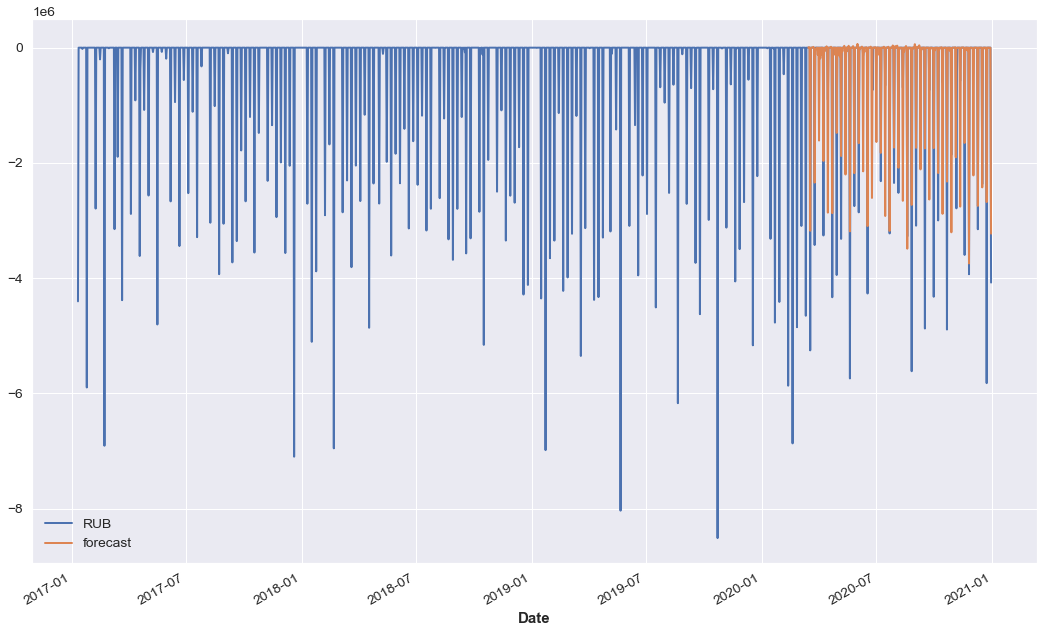

In [15]:
# Отрисовка для LightGBM, тут на глаз видно, что есть вылеты за 0 в положительную сторону, их принудительно обнуляем, т.к. (если правильно понял) у нас транзакции все в одну сторону
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [16]:
# Предварительный результат. НЕ ДЛЯ CUMSUM!
fixed_prediction1d = prediction1d.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

249076.40856139612

In [17]:
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0

In [18]:
# MAE для подправленных данных
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)

246910.31909113683

In [19]:
# Для этого БЕ больше моделей не подобрал

In [20]:
# Подготовка и постройка графика для val части
predict_series = fixed_prediction1d["RUB"]

In [21]:
val_df = pd.DataFrame()
val_df.index = predict_series.index
val_df["y"] = train_2_1d.loc["2020-03-15":]
val_df["yhat"] = predict_series

<AxesSubplot:xlabel='Date'>

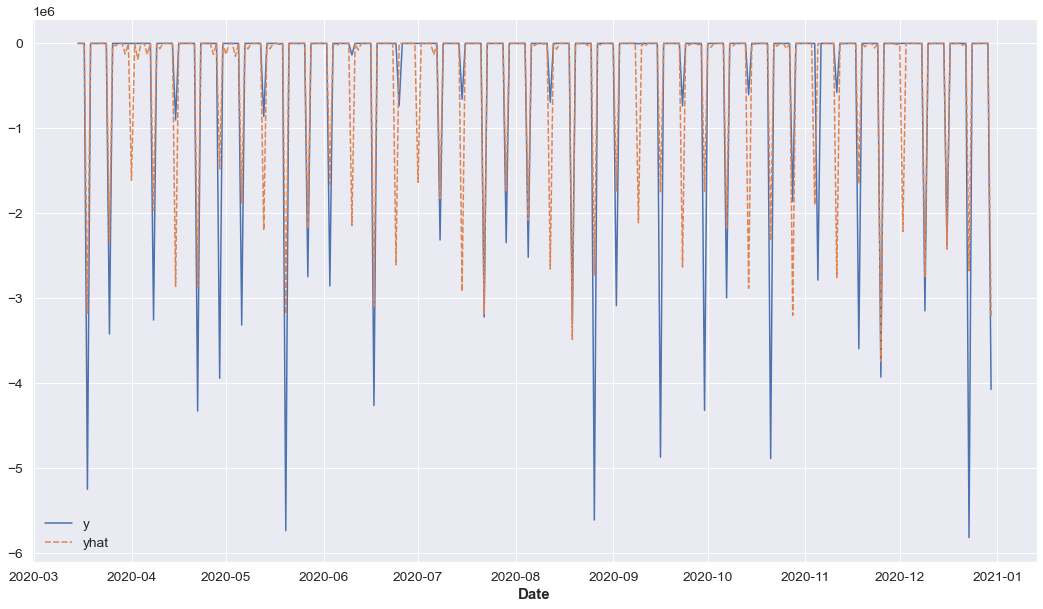

In [22]:
sns.lineplot(data=val_df)

In [23]:
# Делаем refit на полных данных для LightGBM
refit_model1d = LightGBMModel(lags=[-9, -13, -88], output_chunk_length=180)
refit_model1d.fit(series_1d)
refit_prediction1d = refit_model1d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [26]:
# Предикт с разрешением в 1 день
refit_fixed_prediction1d = refit_prediction1d.pd_dataframe()
refit_fixed_prediction1d[refit_fixed_prediction1d["RUB"]>0] = 0
refit_fixed_prediction1d = refit_fixed_prediction1d.iloc[1:]

In [27]:
train_2_ans = pd.DataFrame()
#train_0_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_2_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
train_2_ans["Сумма в RUB"] = refit_fixed_prediction1d["RUB"].values
train_2_ans["Сумма в RUB"] = train_2_ans["Сумма в RUB"].groupby(train_2_ans["Дата транзакции"].dt.month).cumsum().values

train_2_ans["Месяц"] = train_2_ans["Дата транзакции"].dt.month
train_2_ans["БЕ"] = 2


In [28]:
train_2_ans.to_csv("train_2_ans.csv")